<h1 style="text-align:center;font-family:Didot;">Rate of return, risk of portfolio, minimal risk portfolio</h1>

In [12]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

In [2]:
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize': (12, 8)})
sns.set(font_scale=1.5)

In [3]:
def how_much_shift_is_needed(shift):
    gsci = pd.read_excel(os.path.join('data', 'full', 'GSCI.xls'), skiprows=6).iloc[:-1, :]
    gsci.rename({'S&P GSCI Petroleum': 'price', 'Effective date ': 'date'}, inplace=True, axis=1)
    gsci['date'] = pd.to_datetime(gsci['date'])
    gsci['price'] = gsci['price'].shift(shift).fillna(method="bfill")
    gsci.dropna(inplace=True)
    petrol = pd.read_csv(os.path.join('data', 'full', 'petrol.csv'))
    petrol.date = pd.to_datetime(petrol.date)
    petrol.drop(columns=['excise', 'surcharge'], inplace=True)
    diesel = pd.read_csv(os.path.join('data', 'full', 'diesel.csv'))
    diesel.date = pd.to_datetime(diesel.date)
    diesel.drop(columns=['excise', 'surcharge'], inplace=True)
    currency = pd.read_csv(os.path.join('data', 'full', 'PLNUSD.csv'))
    currency.Date = pd.to_datetime(currency.Date)
    currency.rename({'Adj Close': 'price', 'Date': 'date'}, inplace=True, axis=1)
    currency = currency[['date', 'price']]
    currency.dropna(inplace=True)
    market = pd.merge(gsci, currency, on='date', suffixes=['_gsci', '_fx'])
    market['price'] = market.price_gsci / market.price_fx
    market = market[['date', 'price']]
    oil = pd.merge(petrol, diesel, on='date', suffixes=['_petrol', '_diesel'])
    risk = pd.merge(market, oil, on='date')
    log_risk = risk.drop(columns='date').apply(
        lambda col: np.diff(np.log(col)) / np.diff(risk.date).astype(float) * 365.25 * 3600 * 24 * 1e9
        )
    log_risk['date'] = risk.date[1:]
    log_risk.rename({'price': 'gsci', 'price_petrol': 'petrol', 'price_diesel': 'diesel'},
                    inplace=True, axis=1)
    correlation = log_risk.drop(columns='date').corr()
    return np.sum(np.abs(correlation['gsci'].to_numpy())) 

Correlation maximum for shift = 1


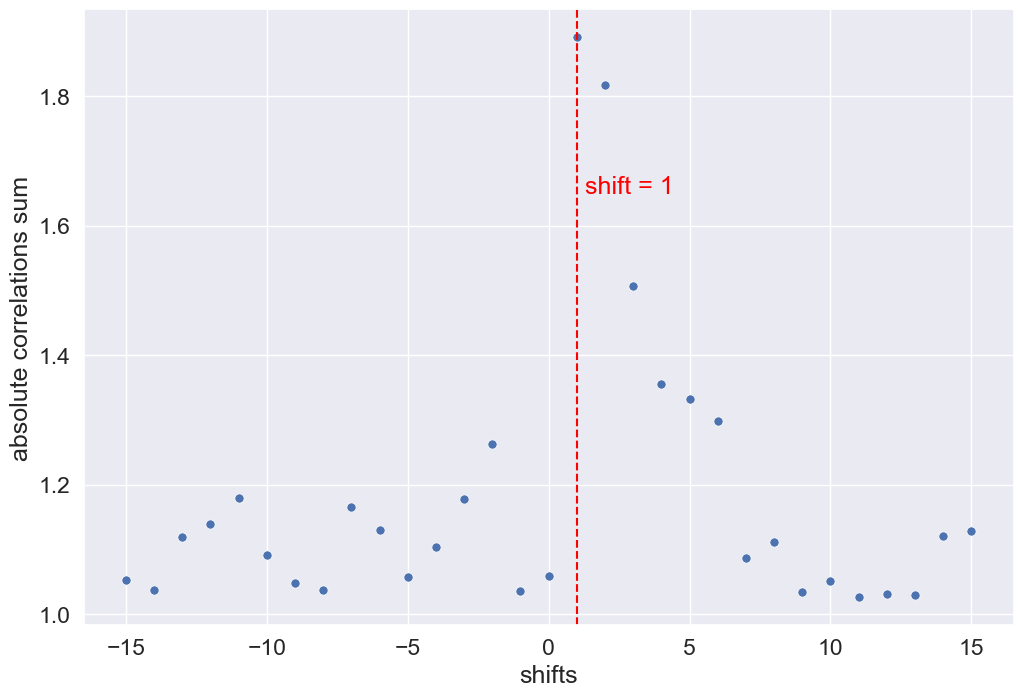

In [4]:
shifts = list(range(-15, 16))
corrs = [how_much_shift_is_needed(shift) for shift in shifts]
idx = np.argmax(corrs) -15
print(f"Correlation maximum for shift = {idx}")
sns.scatterplot(x=shifts, y=corrs, s=44)
plt.xlabel("shifts")
plt.ylabel("absolute correlations sum")
plt.axvline(1, color='red', ls='--')
plt.text(1.3, 1.65, "shift = 1", c="red")
plt.show()

### Reading and prepraing data

In [3]:
gsci = pd.read_excel(os.path.join('data', 'full', 'GSCI.xls'), skiprows=6).iloc[:-1, :]
gsci['S&P GSCI Petroleum'] = gsci['S&P GSCI Petroleum'].shift(1)
gsci.at[0, 'S&P GSCI Petroleum'] = gsci.at[1, 'S&P GSCI Petroleum']
gsci.dropna(inplace=True)
gsci['Effective date '] = pd.to_datetime(gsci['Effective date '])
gsci.rename({'S&P GSCI Petroleum': 'price', 'Effective date ': 'date'}, inplace=True, axis=1)

In [4]:
petrol = pd.read_csv(os.path.join('data', 'full', 'petrol.csv'))
petrol.date = pd.to_datetime(petrol.date)
petrol.drop(columns=['excise', 'surcharge'], inplace=True)

In [5]:
diesel = pd.read_csv(os.path.join('data', 'full', 'diesel.csv'))
diesel.date = pd.to_datetime(diesel.date)
diesel.drop(columns=['excise', 'surcharge'], inplace=True)

In [6]:
currency = pd.read_csv(os.path.join('data', 'full', 'PLNUSD.csv'))
currency.Date = pd.to_datetime(currency.Date)
currency.rename({'Adj Close': 'price', 'Date': 'date'}, inplace=True, axis=1)
currency = currency[['date', 'price']]
currency.dropna(inplace=True)

In [7]:
market = pd.merge(gsci, currency, on='date', suffixes=['_gsci', '_fx'])
market['price'] = market.price_gsci / market.price_fx
market = market[['date', 'price']]

In [8]:
oil = pd.merge(petrol, diesel, on='date', suffixes=['_petrol', '_diesel'])

In [13]:
risk = pd.merge(market, oil, on='date')
log_risk = risk.drop(columns='date').apply(
    lambda col: np.diff(np.log(col)) / np.diff(risk.date).astype(float) * 365.25 * 3600 * 24 * 1e9
)
log_risk['date'] = risk.date[1:]
log_risk.rename({'price': 'gsci', 'price_petrol': 'petrol', 'price_diesel': 'diesel'},
                inplace=True, axis=1)

In [18]:
print(log_risk.drop(columns='date').corr().to_markdown())

|        |     gsci |   petrol |   diesel |
|:-------|---------:|---------:|---------:|
| gsci   | 1        | 0.442696 | 0.4483   |
| petrol | 0.442696 | 1        | 0.759277 |
| diesel | 0.4483   | 0.759277 | 1        |


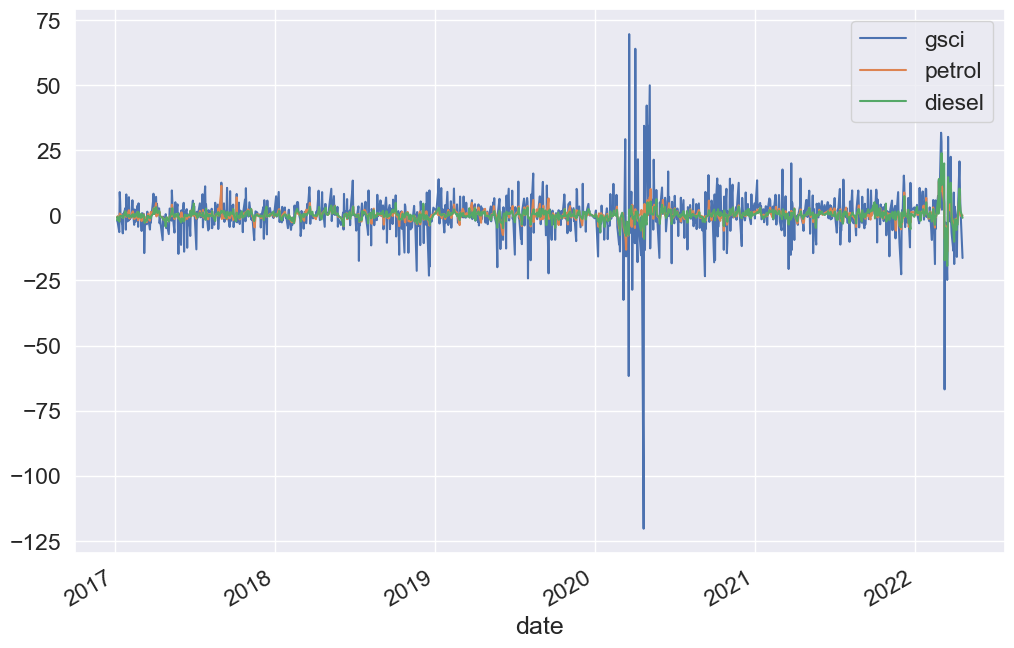

In [13]:
log_risk.plot(kind="line", x='date')
plt.show()

<h2 style="text-align:center;">Part I</h2>

In [15]:
def markdown_printer(variable, dictionary):
    df = pd.DataFrame.from_dict(dictionary)
    s = df.to_markdown()

    print(f'### {variable}')
    print('\n'.join(map(lambda x: x[5:], s.split("\n"))))


def get_logreturns(name):
    df = pd.read_csv(os.path.join('data', 'fit', f'{name}_fit.csv'))

    date = pd.to_datetime(df.date).to_numpy(dtype = 'datetime64[D]')
    data = df.price.to_numpy() / 1000

    diff = (date[1:] - date[:-1]).astype('float64') / 365.25
    return np.diff(np.log(data)) / diff


def portfolio_logreturns(w_petrol):
    df = pd.read_csv(os.path.join('data', 'fit', 'petrol_fit.csv'))
    petrol = df.price.to_numpy() / 1000

    date = pd.to_datetime(df.date).to_numpy(dtype = 'datetime64[D]')
    diff = (date[1:] - date[:-1]).astype('float64') / 365.25

    df = pd.read_csv(os.path.join('data', 'fit', 'diesel_fit.csv'))
    diesel = df.price.to_numpy() / 1000

    return w_petrol * np.diff(np.log(petrol)) / diff + (1 - w_petrol) * np.diff(np.log(diesel)) / diff

In [16]:
diesel_logret = log_risk.diesel.to_numpy()
petrol_logret = log_risk.petrol.to_numpy()
gsci_logret = log_risk.gsci.to_numpy()

### statystyki

In [19]:
markdown_printer("Univariate statistics", {'statistic' : ['mean', 'std'], 
                                           'petrol' : (np.mean(petrol_logret), np.std(petrol_logret)), 
                                           'diesel' : (np.mean(diesel_logret), np.std(diesel_logret))})

### Univariate statistics
| statistic   |   petrol |   diesel |
|:------------|---------:|---------:|
| mean        | 0.127476 | 0.145353 |
| std         | 2.29591  | 2.4921   |


In [20]:
petrol_std = np.std(petrol_logret)
diesel_std = np.std(diesel_logret)
print(f"pertol_std: {petrol_std}, diesel_std: {diesel_std}")

pertol_std: 2.2959116759340095, diesel_std: 2.492099851468002


### Pearson correlation

In [21]:
correlation = stats.pearsonr(diesel_logret, petrol_logret)[0]
print(f"korelacja: {correlation}")

korelacja: 0.7592770194929618


### actual wages
$w_{\text{petrol}}= 0.543, w_{\text{diesel}} = 0.457$

In [22]:
w_petrol = 0.543
portfolio_logret = w_petrol * petrol_logret + (1 - w_petrol) * diesel_logret

np.mean(portfolio_logret), np.std(portfolio_logret)

(0.13564616163462404, 2.237715525670099)

### possible portfolios

In [23]:
weights = np.linspace(0.0, 1.0, 200)
portfolios = [w_petrol * petrol_logret + (1 - w_petrol) * diesel_logret for w_petrol in weights]

stds = np.array(list(map(np.std, portfolios)))
rets = np.array(list(map(np.mean, portfolios)))

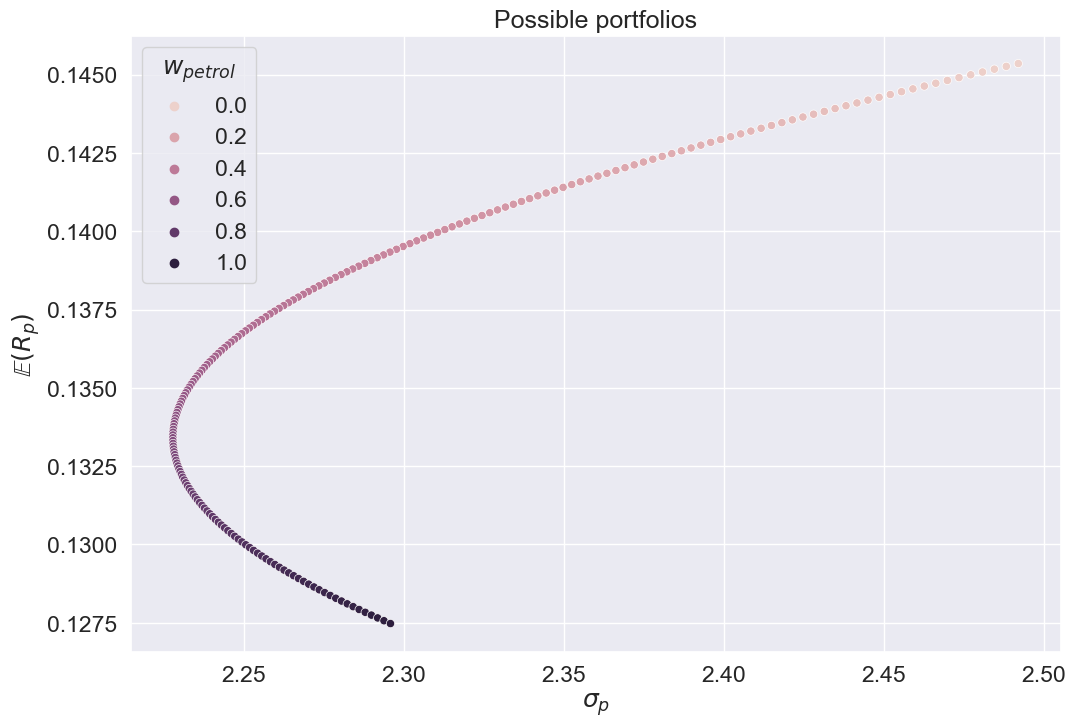

In [24]:
sns.scatterplot(x=stds, y=rets, hue=weights)
plt.xlabel(r"$\sigma_p$")
plt.ylabel(r"$\mathbb{E}(R_p)$")
plt.legend(title=r"$w_{petrol}$")
plt.title("Possible portfolios")
plt.show()

### Minimal risk portfolio

In [25]:
min_weight = (diesel_std**2 - diesel_std * petrol_std * correlation) / (petrol_std**2 + diesel_std**2 - 2 * diesel_std * petrol_std * correlation)
min_weight 

0.668152618015632

In [26]:
weights[np.argmin(stds)]

0.6683417085427136

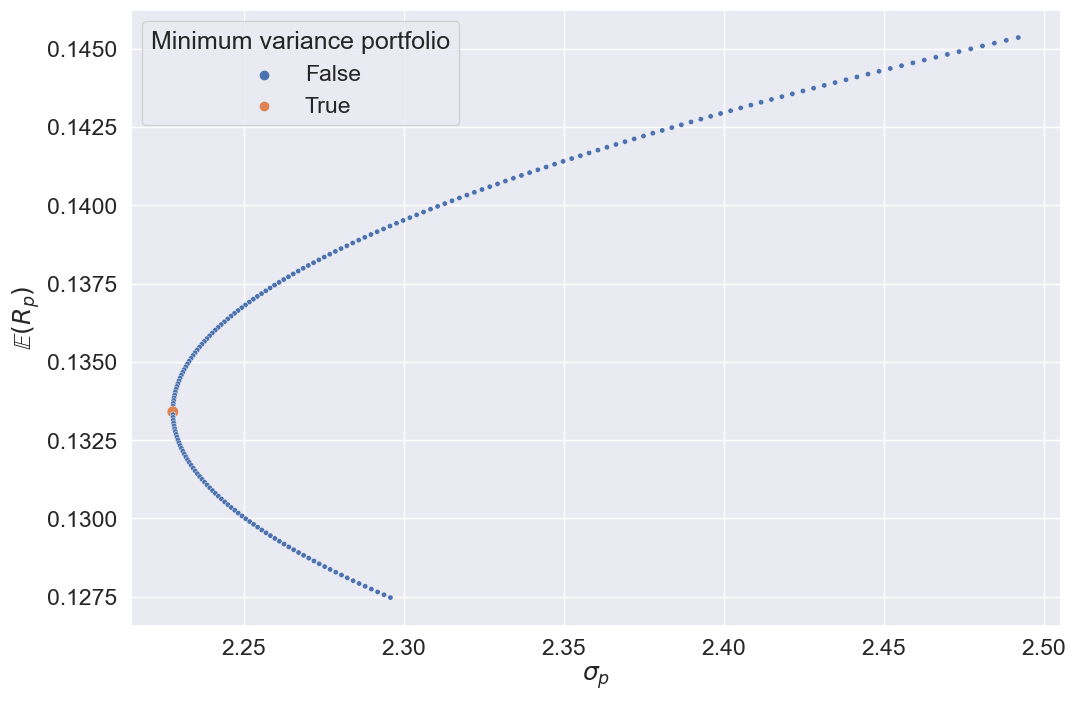

In [27]:
sns.scatterplot(x=stds, y=rets, 
                hue=np.equal(weights, weights[np.argmin(stds)]),
                s=[(70 if i else 15) for i in np.equal(weights, weights[np.argmin(stds)])]
                )
plt.xlabel(r"$\sigma_p$")
plt.ylabel(r"$\mathbb{E}(R_p)$")
plt.legend(title="Minimum variance portfolio")
plt.show()

### Portfolio with given rate of return

$\mathbb{E}(R_p) \leq 14\%$

Portfolio with minimal variance for given rate of return will be the same as in previous case.

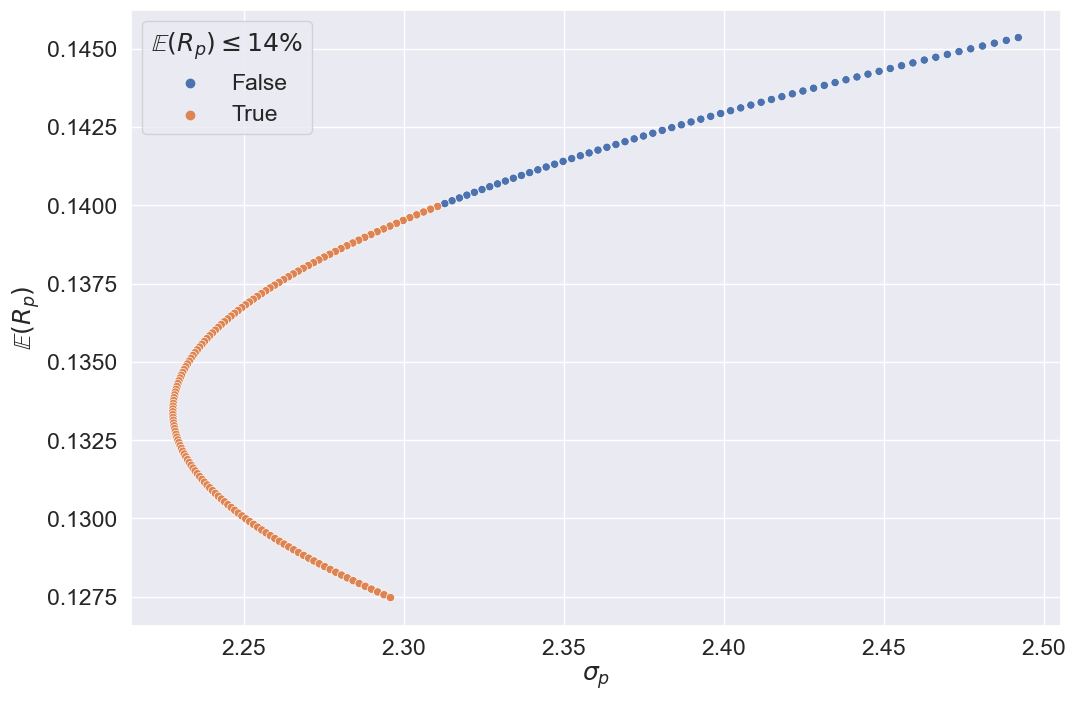

In [28]:
sns.scatterplot(x=stds, y=rets, hue=(rets <= 0.14))
plt.xlabel(r"$\sigma_p$")
plt.ylabel(r"$\mathbb{E}(R_p)$")
plt.legend(title=r"$\mathbb{E}(R_p) \leq 14\%$")
plt.show()

$\mathbb{E}(R_p) \leq 13\%$

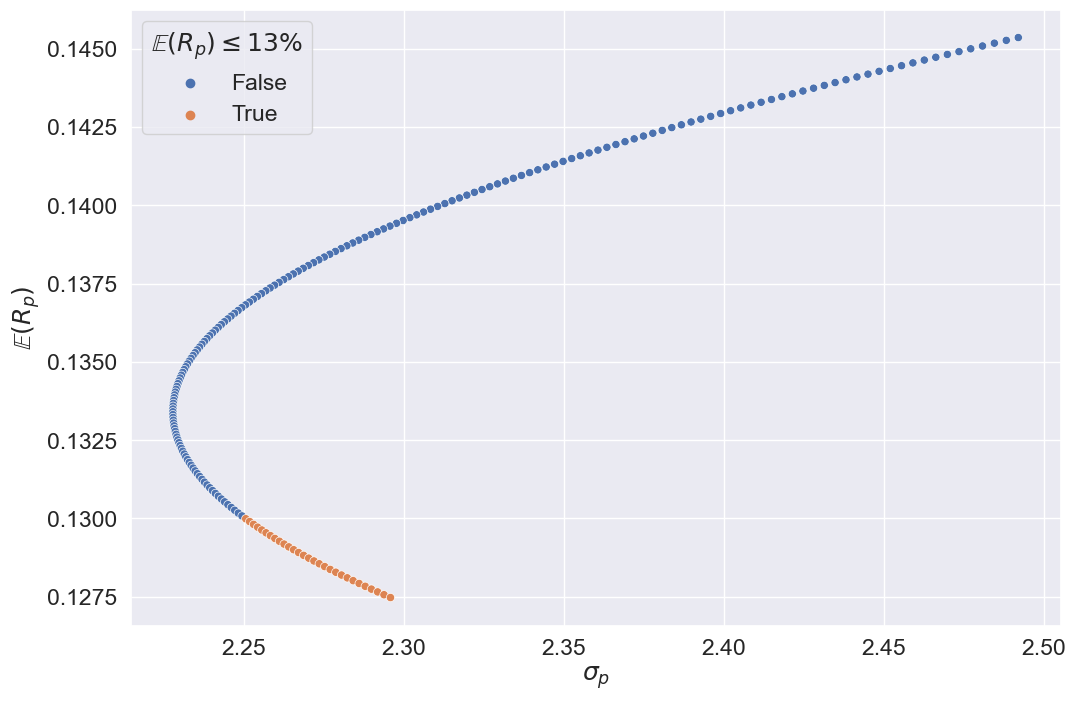

In [29]:
sns.scatterplot(x=stds, y=rets, hue=rets <= 0.13)
plt.xlabel(r"$\sigma_p$")
plt.ylabel(r"$\mathbb{E}(R_p)$")
plt.legend(title=r"$\mathbb{E}(R_p) \leq 13\%$")
plt.show()

In [30]:
weight_13 = weights[rets <= 0.13][np.argmin(stds[rets <= 0.13])]
weight_13

0.8592964824120604

### Minimal Sharpe ratio

Let's assume that rate of return is equal to $2\%$.

In [31]:
r = 0.02
S = - (rets - r) / stds

weights[np.argmax(S)]

1.0

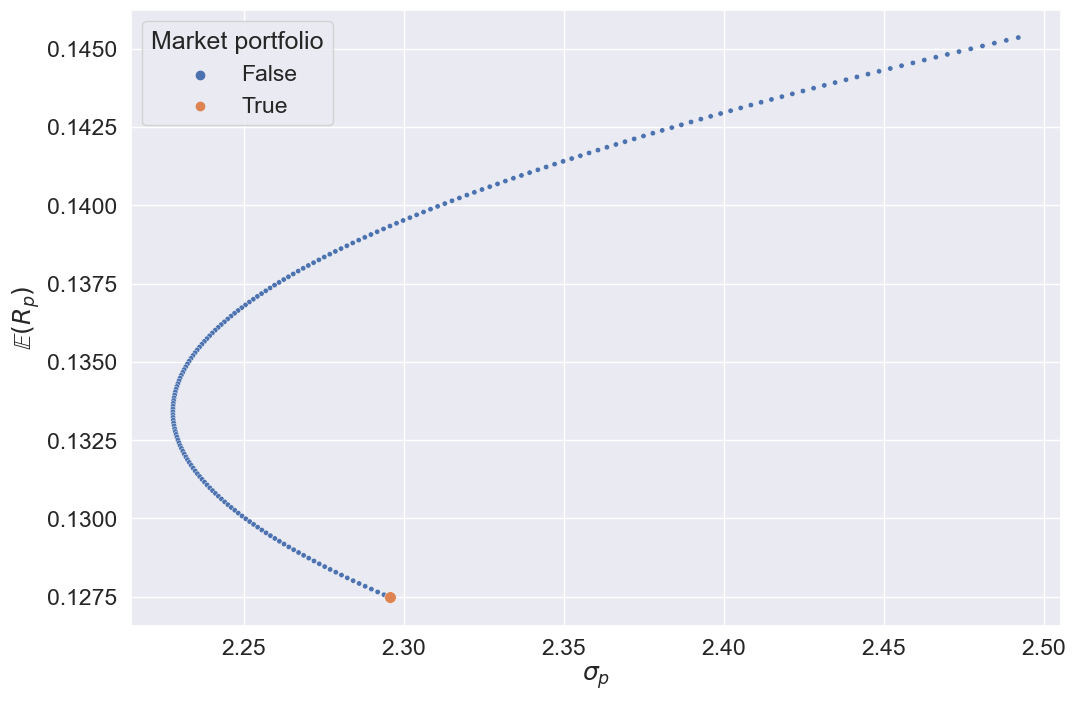

In [32]:
sns.scatterplot(x=stds, y=rets, hue=np.equal(weights, weights[np.argmax(S)]), 
                s=[(70 if i else 15) for i in np.equal(weights, weights[np.argmax(S)])])
plt.xlabel(r"$\sigma_p$")
plt.ylabel(r"$\mathbb{E}(R_p)$")
plt.legend(title="Market portfolio")
plt.show()

<h2 style="text-align:center;">Part II</h2>

In [33]:
beta_diesel, alpha_diesel = np.polyfit(gsci_logret, diesel_logret, 1)
beta_petrol, alpha_petrol = np.polyfit(gsci_logret, petrol_logret, 1)

print(f"beta_diesel: {beta_diesel}, alpha_diesel: {alpha_diesel}")
print(f"beta_petrol: {beta_petrol}, alpha_petrol: {alpha_petrol}")

beta_diesel: 0.12382897512947447, alpha_diesel: 0.10812467824557595
beta_petrol: 0.11265460991604985, alpha_petrol: 0.09360727575667833


Both considered risk variables react in a similar way to changes in the risk of the system selected by us.

In [34]:
R_diesel = beta_diesel * gsci_logret + alpha_diesel 
R_petrol = beta_petrol * gsci_logret + alpha_petrol

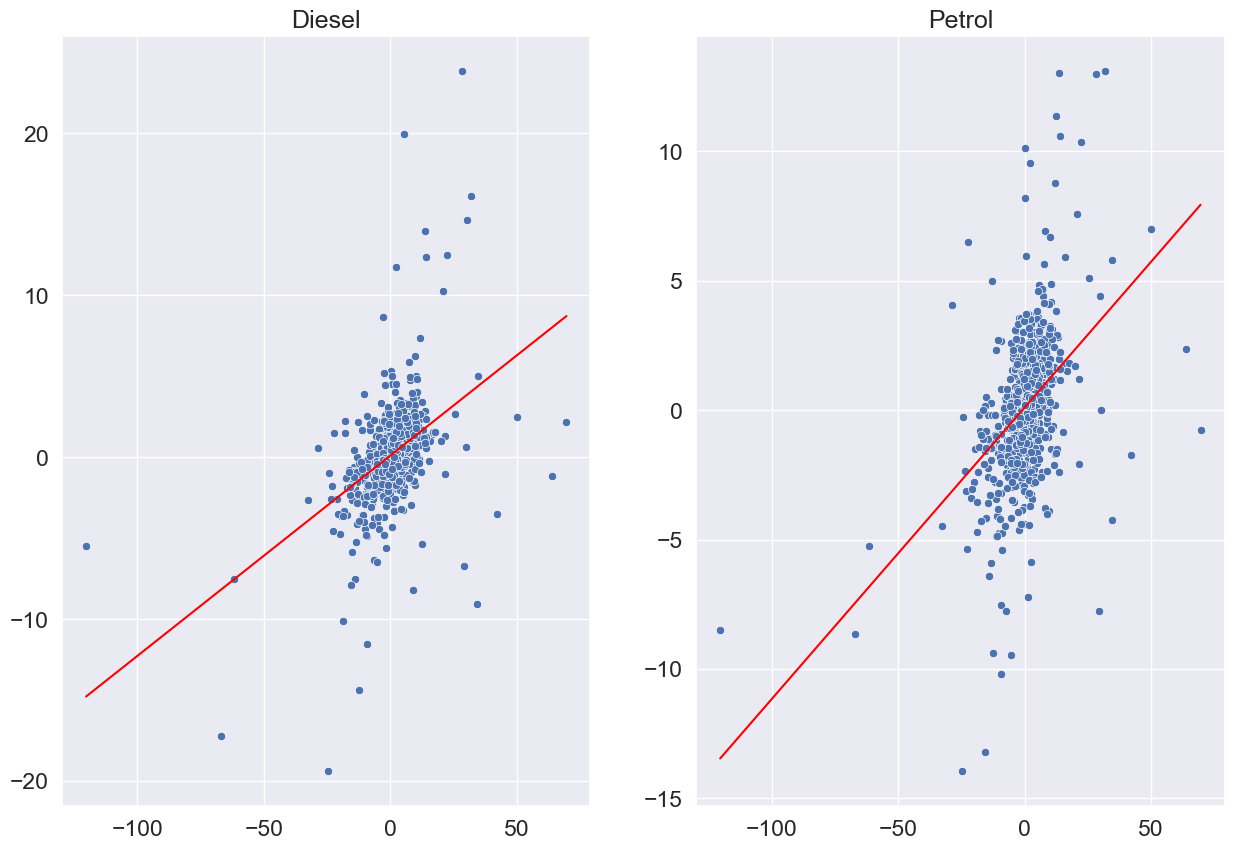

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(15, 10))

sns.scatterplot(x=gsci_logret, y=diesel_logret, ax=ax[0])
sns.lineplot(x=gsci_logret, y=R_diesel, ax=ax[0], color="red")
ax[0].set_title("Diesel")
sns.scatterplot(x=gsci_logret, y=petrol_logret, ax=ax[1])
sns.lineplot(x=gsci_logret, y=R_petrol, ax=ax[1], color="red")
ax[1].set_title("Petrol")
plt.show()

In [36]:
diesel_res = diesel_logret - R_diesel
petrol_res = petrol_logret - R_petrol
T = len(diesel_logret)

In [37]:
stats.pearsonr(diesel_res, petrol_res)

PearsonRResult(statistic=0.6996911955907461, pvalue=6.637814492264709e-154)

In [38]:
np.mean(R_diesel), np.mean(R_petrol)

(0.14535333349107551, 0.12747640557864184)

In [39]:
var_res_diesel = np.sum((diesel_res)**2) / (T-1)
var_res_petrol = np.sum((petrol_res)**2) / (T-1)
print(f"Variance of diesel residuals: {var_res_diesel}")
print(f"Variance of petrol residuals: {var_res_petrol}")

Variance of diesel residuals: 4.967177693099686
Variance of petrol residuals: 4.242233817837758


In [40]:
R_diesel_variance = var_res_diesel + np.var(gsci_logret, ddof=1) * beta_diesel ** 2
R_petrol_variance = var_res_petrol + np.var(gsci_logret, ddof=1) * beta_petrol ** 2
print(f"Diesel R variance: {R_diesel_variance}")
print(f"Petrol R variance: {R_petrol_variance}")

Diesel R variance: 6.216533363599998
Petrol R variance: 5.276278895251352


In [41]:
diesel_R_squared = beta_diesel**2 * np.var(gsci_logret, ddof=1) / np.var(diesel_logret, ddof=1)
petrol_R_squared = beta_petrol**2 * np.var(gsci_logret, ddof=1) / np.var(petrol_logret, ddof=1)
print(f"Diesel R^2: {diesel_R_squared}")
print(f"Petrol R^2: {petrol_R_squared}")

Diesel R^2: 0.20097304999853008
Petrol R^2: 0.19597998853779947


In [42]:
alphas = np.array([alpha_petrol, alpha_diesel])
betas = np.array([beta_petrol, beta_diesel])
var_res = np.array([var_res_petrol, var_res_diesel])
gsci_mean = gsci_logret.mean()
gsci_var = gsci_logret.var(ddof=1)

In [43]:
def single_market_portfolio(petrol_weight):
    return petrol_weight * R_petrol + (1 - petrol_weight) * R_diesel


def portfolio_return(petrol_weight):
    weights = np.array([petrol_weight, 1 - petrol_weight])
    return (weights * (alphas + betas * gsci_mean)).sum()


def portfolio_risk(petrol_weight):
    weights = np.array([petrol_weight, 1 - petrol_weight])
    return np.sqrt((weights * betas).sum()**2 * gsci_var + (weights**2 * var_res).sum())

In [44]:
our_portfolio = single_market_portfolio(w_petrol)

In [45]:
np.mean(our_portfolio), portfolio_risk(w_petrol)

(0.13564616163462404, 1.8488174191028255)

In [46]:
possible_portfolios = [single_market_portfolio(petrol_weight) for petrol_weight in weights]
stds_2 = np.array(list(map(portfolio_risk, weights)))
rets_2 = np.array(list(map(np.mean, possible_portfolios)))

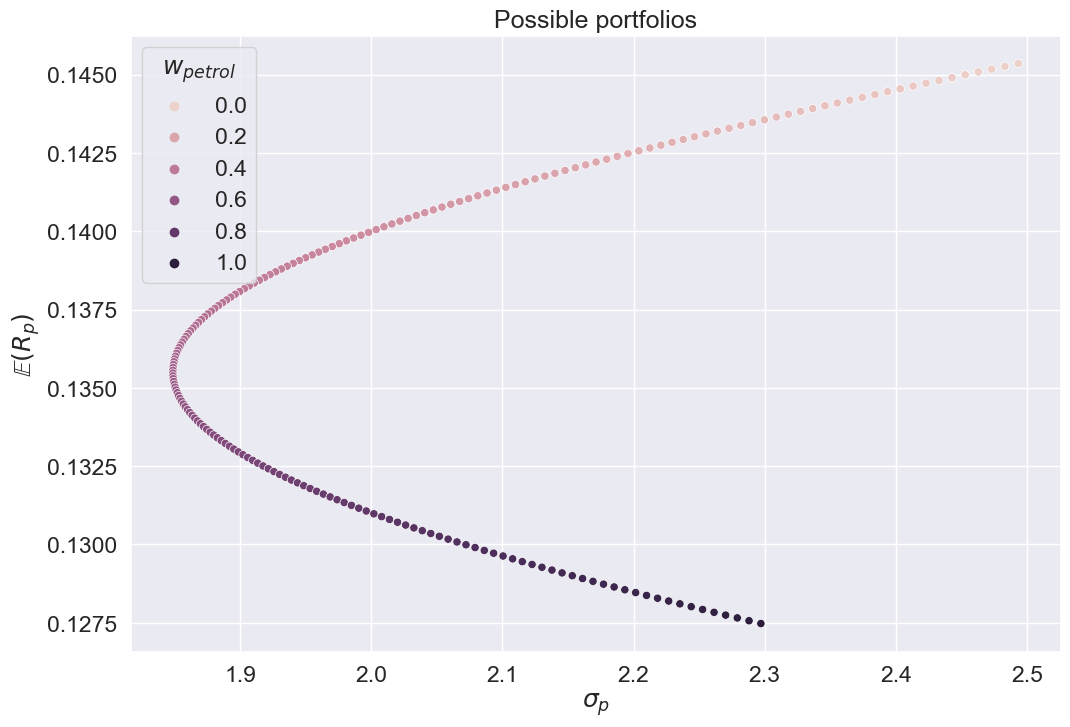

In [47]:
sns.scatterplot(x=stds_2, y=rets_2, hue=weights)
plt.xlabel(r"$\sigma_p$")
plt.ylabel(r"$\mathbb{E}(R_p)$")
plt.legend(title=r"$w_{petrol}$")
plt.title("Possible portfolios")
plt.show()

### Minimal risk portfolio

In [48]:
weights[np.argmin(stds_2)]

0.5527638190954774

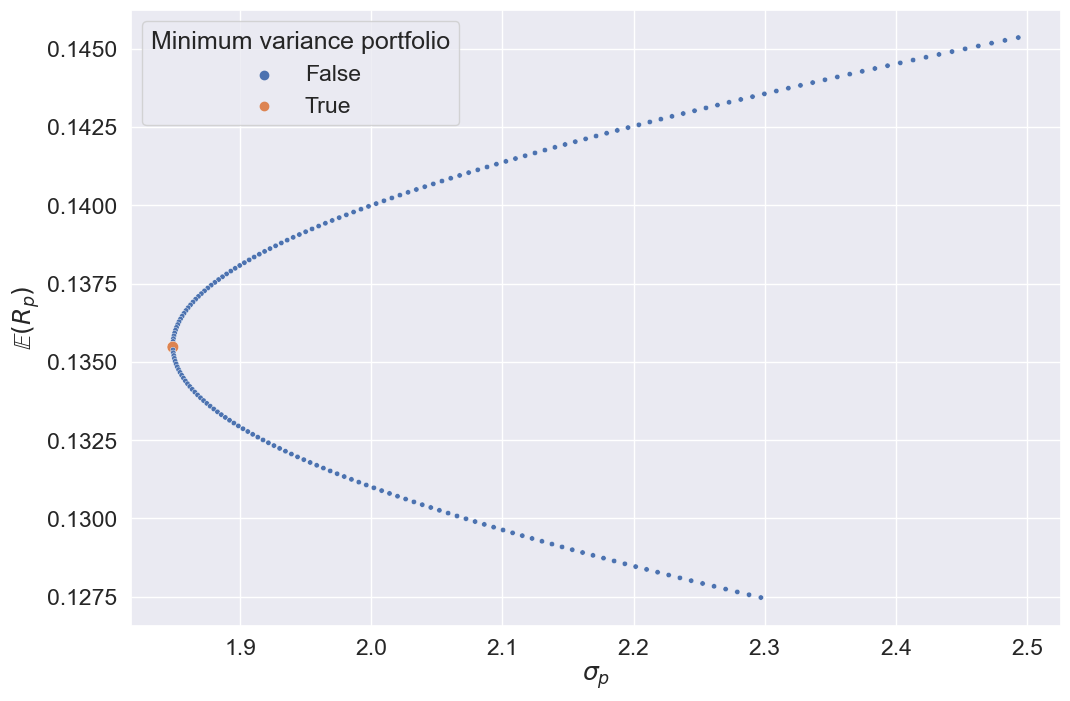

In [49]:
sns.scatterplot(x=stds_2, y=rets_2, 
                hue=np.equal(weights, weights[np.argmin(stds_2)]),
                s=[(70 if i else 15) for i in np.equal(weights, weights[np.argmin(stds_2)])]
                )
plt.xlabel(r"$\sigma_p$")
plt.ylabel(r"$\mathbb{E}(R_p)$")
plt.legend(title="Minimum variance portfolio")
plt.show()

### Portfolio with given rate of return

$\mathbb{E}(R_p) \leq 14\%$

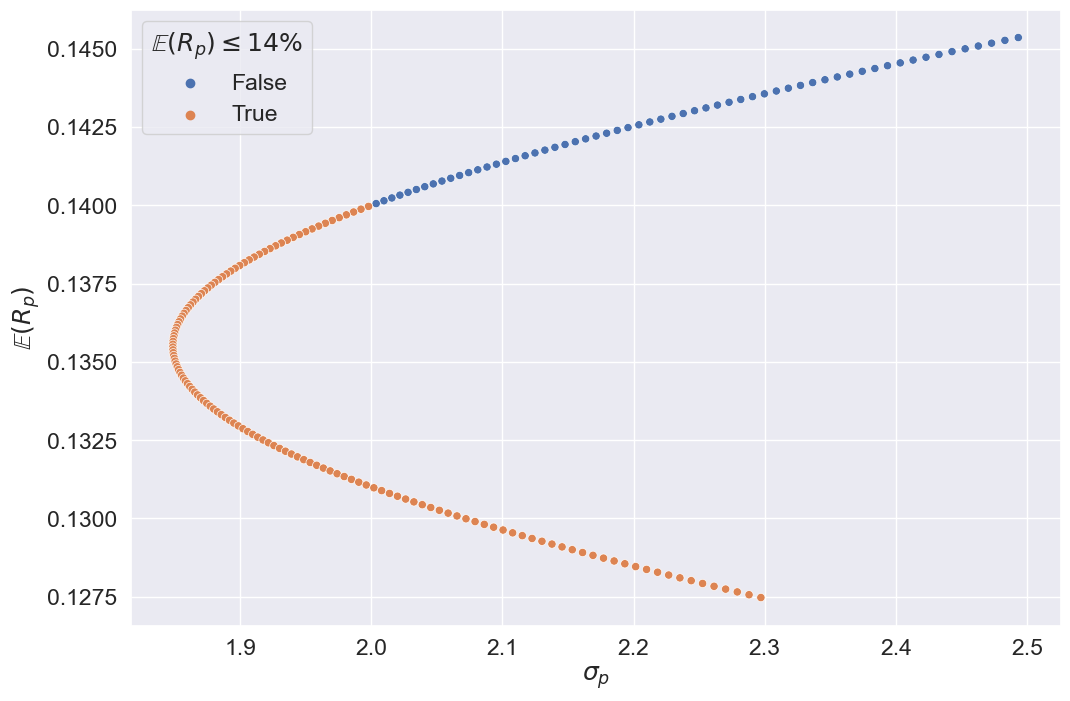

In [50]:
sns.scatterplot(x=stds_2, y=rets_2, hue=(rets_2 <= 0.14))
plt.xlabel(r"$\sigma_p$")
plt.ylabel(r"$\mathbb{E}(R_p)$")
plt.legend(title=r"$\mathbb{E}(R_p) \leq 14\%$")
plt.show()

$\mathbb{E}(R_p) \leq 13\%$

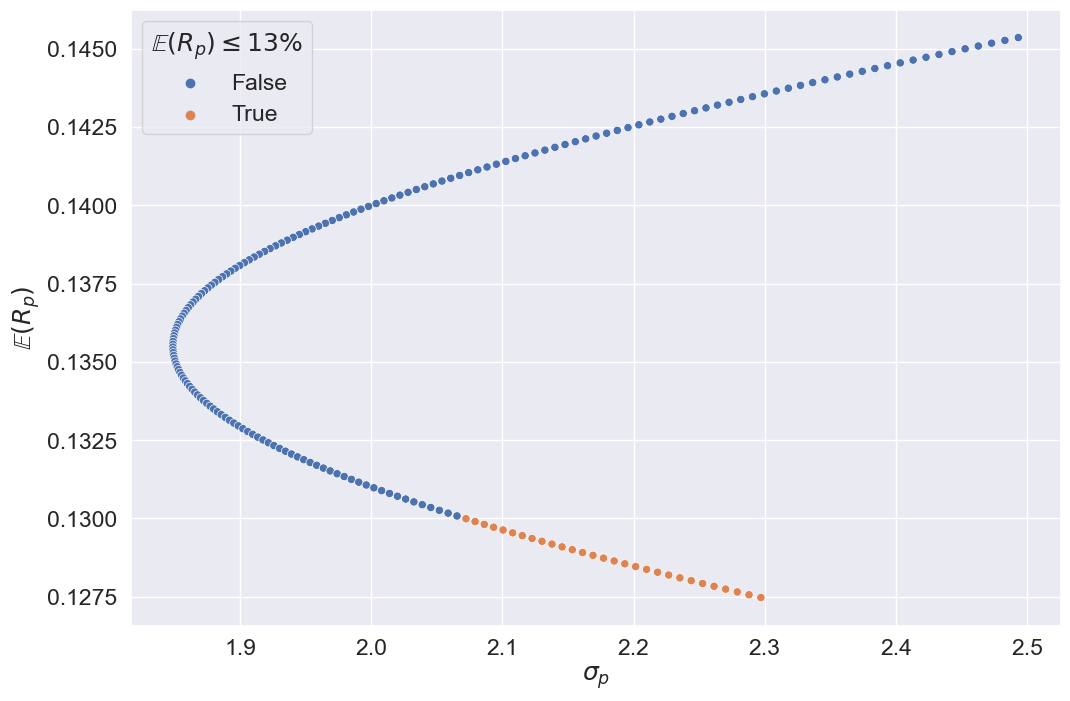

In [51]:
sns.scatterplot(x=stds_2, y=rets_2, hue=rets_2 <= 0.13)
plt.xlabel(r"$\sigma_p$")
plt.ylabel(r"$\mathbb{E}(R_p)$")
plt.legend(title=r"$\mathbb{E}(R_p) \leq 13\%$")
plt.show()

In [52]:
weight_13 = weights[rets <= 0.13][np.argmin(stds[rets <= 0.13])]
weight_13

0.8592964824120604

### Minimal Sharpe ratio

Let's assume that rate of return is equal to $2\%$.

In [53]:
r = 0.02
S_2 = - (rets_2 - r) / stds_2

weights[np.argmax(S_2)]

1.0

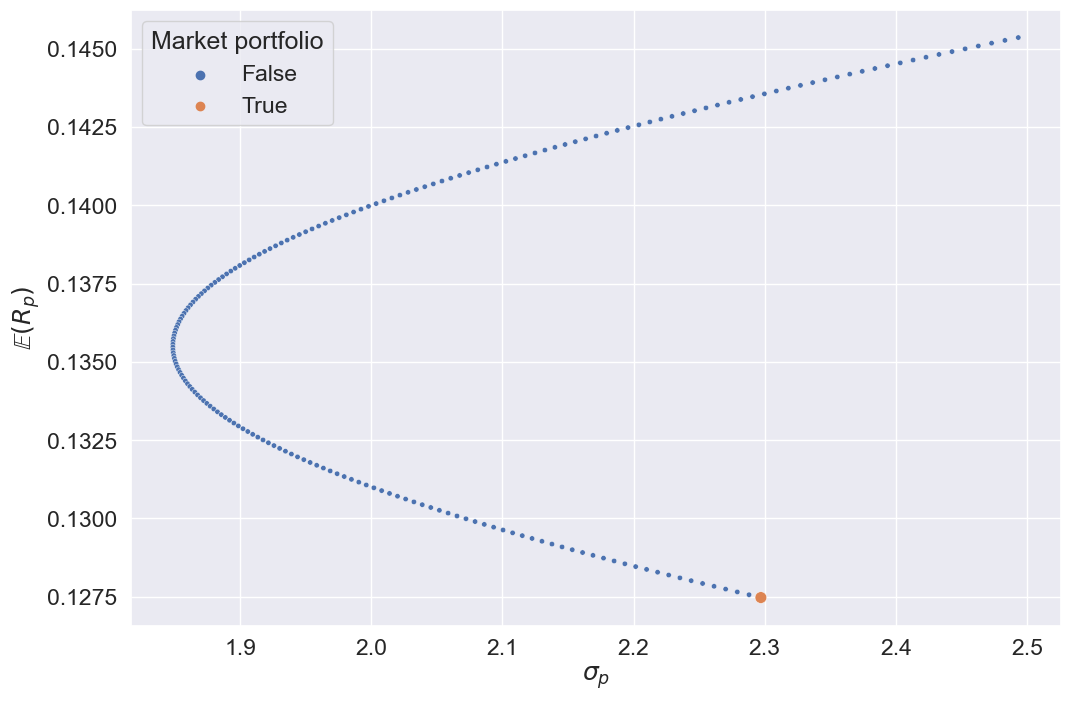

In [54]:
sns.scatterplot(x=stds_2, y=rets_2, hue=np.equal(weights, weights[np.argmax(S_2)]), 
                s=[(70 if i else 15) for i in np.equal(weights, weights[np.argmax(S_2)])])
plt.xlabel(r"$\sigma_p$")
plt.ylabel(r"$\mathbb{E}(R_p)$")
plt.legend(title="Market portfolio")
plt.show()